In [99]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.random as rnd
import theano
import theano.tensor as T
import lasagne
import time
import gzip
import matplotlib.pyplot as plt
%matplotlib inline
from rnn_lib import *
from sklearn.preprocessing import OneHotEncoder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
%reload_ext autoreload

In [9]:
#print(theano.config)

In [89]:
def load_mnist_images(filename):
    # Read the inputs in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=16)
    # The inputs are vectors now, we reshape them to monochrome 2D images,
    # following the shape convention: (examples, channels, rows, columns)
    data = data.reshape(-1, 28, 28)
    # The inputs come as bytes, we convert them to float32 in range [0,1].
    # (Actually to range [0, 255/256], for compatibility to the version
    # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
    return data

def load_mnist_labels(filename):
    # Read the labels in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    # The labels are vectors of integers now, that's exactly what we want.
    return data


# We can now download and read the training and test set images and labels.
X_train = load_mnist_images('train-images-idx3-ubyte.gz')
y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [38]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

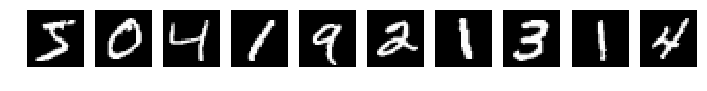

In [39]:
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.axis('off')

In [90]:
X_train = X_train.reshape((60000, 784))
X_test = X_test.reshape((10000, 784))

In [80]:
# a = np.zeros((y_train.size, 10), dtype=np.int)
# a[np.arange(y_train.size), y_train] = 1
# y_train = a

In [81]:
# a = np.zeros((y_test.size, 10), dtype=np.int)
# a[np.arange(y_test.size), y_test] = 1
# y_test = a

In [67]:
NUM_EPOCHS = 100
BATCH_SIZE = 16
N_HIDDEN = 100
SEQ_LEN = 784
TRAIN_SIZE = 60000
TEST_SIZE = 10000
GRAD_CLIP = 10

In [86]:
# cross-entropy
# ys are indices of chars, x is a matrix (? BATCH_SIZE * SEQ_LEN, VOCAB_SIZE)
def lsmCE(x,y):
    print(y)
    return -T.clip(x,-20,0)[T.arange(y.shape[0]), y]

In [48]:
# Технические вещи

# Вспомогательная функция для запаковки результата обучения 
def pack(network, inp, target, train_err, test_err,
         train_acc, test_acc, train_fn, test_fn, norm):
    return {'network':network,
            'inp':inp,
            'target':target,
            
            'train_err':train_err,
            'test_err':test_err,
            'train_acc':train_acc, 
            'test_acc':test_acc, 
            'train_fn':train_fn, 
            'test_fn':test_fn,
            'norm':norm,
            } 

In [96]:
# Create a network with particular initialization for parameters
def create_network(seq_len, dim, hidden, rnn_type):
    print("Building network ...")
    inp = T.tensor3('input', dtype='float64')
    # Matrix of size BATCH_SIZE * 1 to match network's output
    target_values = T.ivector('target_output')
    network = build_network(inp, seq_len, dim, hidden, rnn_type)
    print("The network has {} params".format(lasagne.layers.count_params(network)))
    return (network, inp, target_values)

In [103]:
def train(network, inp, target_values, Xtrain, ytrain, Xtest, ytest,
              filename, lr, num_epochs=NUM_EPOCHS):
    num_batches = TRAIN_SIZE // BATCH_SIZE
    train_err=np.zeros(num_epochs)
    train_acc=np.zeros(num_epochs)
    test_err=np.zeros(num_epochs)
    test_acc=np.zeros(num_epochs)
    norm_hist=np.zeros(num_epochs)
    
    network_output = lasagne.layers.get_output(network)
    cr_ent = lasagne.objectives.categorical_crossentropy(network_output, target_values).mean()
    acc_score = lasagne.objectives.categorical_accuracy(
        network_output, target_values).mean(dtype=theano.config.floatX) * 100
    
    # Retrieve all parameters from the network
    all_params = lasagne.layers.get_all_params(network)
    print("Computing updates ...")
    all_grads = T.grad(cr_ent, all_params)
    scaled_grads, grad_norm = lasagne.updates.total_norm_constraint(all_grads, GRAD_CLIP, return_norm=True)
    lr_var = theano.shared(lr)
    updates = lasagne.updates.sgd(scaled_grads, all_params, learning_rate=lr_var)

    print("Compiling functions ...")    
    train_fn = theano.function([inp, target_values], [cr_ent, acc_score, grad_norm, network_output],
                               updates=updates, allow_input_downcast=True)
    test_fn = theano.function([inp, target_values], [cr_ent, acc_score], allow_input_downcast=True)
    get_output = theano.function([inp], network_output, allow_input_downcast=True)
    
    train_idxs = np.arange(TRAIN_SIZE)
    np.random.shuffle(train_idxs)
    for epoch in range(num_epochs):
        start_time = time.time()
        for batch in range(num_batches):
            idx = train_idxs[BATCH_SIZE * batch : BATCH_SIZE * (batch + 1)]            
            err, acc, norm, out = train_fn(Xtrain[idx, :, np.newaxis], ytrain[idx])
            if np.isnan(err):
                print("Error: crossentropy became nan")
                np.save("net_output", out)
                raise
            elif np.isnan(norm):
                print("Error: grad norm is nan")
                raise
            train_err[epoch] += err
            train_acc[epoch] += acc
            
            #if batch == num_batches // 4:
            #    print("25%", end=" ")
            #if batch == num_batches // 2:
            #    print("50%", end=" ")
            #if batch == num_batches // 4 * 3:
            #    print("75%")
        
        np.random.shuffle(train_idxs)
            
        train_err[epoch] /= num_batches
        train_acc[epoch] /= num_batches
        
        terr, tacc = test_fn(Xtest[:, :, np.newaxis], ytest)
        test_err[epoch] = terr
        test_acc[epoch] = tacc
        norm_hist[epoch] = norm.item()
        
        print("Epoch {} loss / acc test = {:.4f}, {:.4f} \t"
              "train = {:.4f}, {:.4f} norm = {:.4f} \t time = {:.2f}s".
              format(epoch, test_err[epoch], test_acc[epoch], 
                     train_err[epoch], train_acc[epoch], norm.item(), time.time() - start_time))
    
    np.save(file=filename, arr=lasagne.layers.get_all_param_values(network))
    return pack(network, inp, target_values, train_err, test_err, train_acc, test_acc, train_fn, test_fn, norm_hist)

In [ ]:
net, inp, tar = create_network(SEQ_LEN, 1, N_HIDDEN, 'nprnn')
nprnn1 = train(net, inp, tar, X_train, y_train_, X_test, y_test_, "mnist-data/nprnn1", 1e-4, num_epochs=33)
np.save("mnist-data/acc1", nprnn1["test_acc"])
np.save("mnist-data/err1", nprnn1["test_err"])

Building network ...
The network has 11310 params
Computing updates ...
Compiling functions ...


In [ ]:
# COOL DOWN LEARNING RATE AFTER 30 EPOCHS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
# net, inp, tar = create_network(build_network_np)
# weights = np.load("nprnn1.npy")
# lasagne.layers.set_all_param_values(net, weights)

In [ ]:
nprnn1 = train_sgd(nprnn1["network"], nprnn1["inp"], nprnn1["target"],
                   X_train, y_train, X_test, y_test, "nprnn1", 1e-5, num_epochs=33)
np.save("acc3", nprnn1["test_acc"])
np.save("err3", nprnn1["test_err"])

Computing updates ...
Compiling functions ...
25% 50% 75%
Epoch 0 loss / acc test = 2.2970, 12.1000 	train = 2.2963, 12.2983 norm = 0.3282 	 time = 544.89s	25% 50% 75%
Epoch 1 loss / acc test = 2.2968, 12.1000 	train = 2.2961, 12.3083 norm = 0.3289 	 time = 558.65s	25% 50% 75%
Epoch 2 loss / acc test = 2.2967, 12.1000 	train = 2.2959, 12.3133 norm = 0.3297 	 time = 562.69s	25% 50% 75%
Epoch 3 loss / acc test = 2.2965, 12.1000 	train = 2.2956, 12.3233 norm = 0.3305 	 time = 557.25s	25% 50% 75%
Epoch 4 loss / acc test = 2.2963, 12.1000 	train = 2.2954, 12.3300 norm = 0.3313 	 time = 559.49s	25% 50% 75%
Epoch 5 loss / acc test = 2.2961, 12.1100 	train = 2.2951, 12.3317 norm = 0.3345 	 time = 563.65s	25% 50% 75%
Epoch 6 loss / acc test = 2.2959, 12.1200 	train = 2.2948, 12.3333 norm = 0.3355 	 time = 557.41s	25% 50% 75%
Epoch 7 loss / acc test = 2.2956, 12.1200 	train = 2.2945, 12.3367 norm = 0.3365 	 time = 557.89s	25% 50% 75%
Epoch 8 loss / acc test = 2.2954, 12.1200 	train = 2.2942, 12.

In [ ]:
nprnn1 = train_sgd(nprnn1["network"], nprnn1["inp"], nprnn1["target"],
                   X_train, y_train, X_test, y_test, "nprnn1", 1e-6, num_epochs=33)
np.save("acc4", nprnn1["test_acc"])
np.save("err4", nprnn1["test_err"])

Computing updates ...
Compiling functions ...


In [46]:
np.load("acc4.npy")

array([ 20.68,  20.68,  20.69,  20.69,  20.68,  20.69,  20.69,  20.69,
        20.69,  20.69,  20.69,  20.71,  20.71,  20.73,  20.73,  20.75,
        20.74,  20.75,  20.78,  20.79,  20.81,  20.8 ,  20.84,  20.84,
        20.84,  20.85,  20.87,  20.87,  20.91,  20.92,  20.91,  20.9 ,
        20.91])

## IRNN

In [ ]:
net, inp, tar = create_network(build_network_identity)
irnn1 = train_sgd(net, inp, tar, X_train, y_train, X_test, y_test, "irnn/irnn1", 1e-8, num_epochs=10)

Building network ...
The network has 11310 params
Computing updates ...
Compiling functions ...


In [90]:
np.save("irnn/irnn-acc1", irnn1["test_acc"])
np.save("irnn/irnn-err1", irnn1["test_err"])
np.save("irnn/irnn-norm1", irnn1["norm"])

In [95]:
np.load("irnn/irnn-acc1.npy")

array([  7.42,   8.12,   7.28,  10.03,   9.92,   9.74,  11.33,  13.4 ,
        13.12,  12.91])

In [ ]:
irnn1 = train_sgd(irnn1["network"], irnn1["inp"], irnn1["target"],
                  X_train, y_train, X_test, y_test, "irnn/irnn1", 1e-8, num_epochs=20)
np.save("irnn/irnn-acc2", irnn1["test_acc"])
np.save("irnn/irnn-err2", irnn1["test_err"])
np.save("irnn/irnn-norm2", irnn1["norm"])

Computing updates ...
Compiling functions ...


In [97]:
np.load("irnn/irnn-acc2.npy")

array([ 12.78,  12.91,  12.94,  13.21,  14.17,  15.01,  15.22,  15.31,
        15.3 ,  15.33,  15.37,  15.39,  15.39,  15.4 ,  15.44,  15.54,
        15.69,  15.84,  15.96,  16.08])

In [ ]:
irnn1 = train_sgd(irnn1["network"], irnn1["inp"], irnn1["target"],
                  X_train, y_train, X_test, y_test, "irnn/irnn1", 1e-8, num_epochs=30)
np.save("irnn/irnn-acc3", irnn1["test_acc"])
np.save("irnn/irnn-err3", irnn1["test_err"])
np.save("irnn/irnn-norm3", irnn1["norm"])

Computing updates ...
Compiling functions ...


In [ ]:
irnn1 = train_sgd(irnn1["network"], irnn1["inp"], irnn1["target"],
                  X_train, y_train, X_test, y_test, "irnn/irnn1", 1e-8, num_epochs=20)
np.save("irnn/irnn-acc4", irnn1["test_acc"])
np.save("irnn/irnn-err4", irnn1["test_err"])
np.save("irnn/irnn-norm4", irnn1["norm"])

Computing updates ...
Compiling functions ...


In [104]:
np.load("irnn/irnn-acc3.npy")

array([ 16.24,  16.38,  16.51,  16.63,  16.8 ,  16.9 ,  17.17,  17.31,
        17.41,  17.62,  17.81,  17.89,  17.93,  18.08,  18.2 ,  18.25,
        18.24,  18.13,  18.14,  18.14,  18.11,  18.12,  18.12,  18.12,
        18.06,  18.09,  18.04,  18.02,  17.95,  17.95])

In [103]:
np.load("irnn/irnn-acc4.npy")

array([ 17.98,  17.96,  17.9 ,  17.86,  17.9 ,  17.91,  17.87,  17.87,
        17.85,  17.88,  17.88,  17.9 ,  17.88,  17.88,  17.87,  17.92,
        17.93,  17.96,  17.97,  17.96])

In [ ]:
irnn1 = train_sgd(irnn1["network"], irnn1["inp"], irnn1["target"],
                  X_train, y_train, X_test, y_test, "irnn/irnn1", 1e-8, num_epochs=20)
np.save("irnn/irnn-acc5", irnn1["test_acc"])
np.save("irnn/irnn-err5", irnn1["test_err"])
np.save("irnn/irnn-norm5", irnn1["norm"])

Computing updates ...
Compiling functions ...


In [107]:
np.load("irnn/irnn-acc5.npy")

array([ 17.94,  17.98,  17.99,  18.01,  18.03,  18.05,  18.04,  18.05,
        18.12,  18.12,  18.11,  18.13,  18.14,  18.17,  18.2 ,  18.24,
        18.29,  18.29,  18.28,  18.29])

## LSTM

In [ ]:
net, inp, tar = create_network(build_lstm)
lstm = train_sgd(net, inp, tar, X_train, y_train, X_test, y_test, "lstm/lstm1", 1e-2, 1, num_epochs=10)

Building network ...
The network has 42310 params
Computing updates ...
Compiling functions ...


In [4]:
np.save("lstm/lstm-acc1", lstm["test_acc"])
np.save("lstm/lstm-err1", lstm["test_err"])
np.save("lstm/lstm-norm1", lstm["norm"])

NameError: name 'lstm' is not defined

кернел всё время умирает :(

## nRNN

In [59]:
net, inp, tar = create_network(build_network_norm)

Building network ...
The network has 11310 params


In [60]:
norm_rnn = train_sgd(net, inp, tar, X_train, y_train, X_test, y_test, "nrnn/nrnn1", 1e-4, 10, num_epochs=10)

Computing updates ...
Compiling functions ...
25% 50% 75%
Epoch 0 loss / acc test = 2.3008, 12.1100 	train = 2.3010, 11.5000 norm = 0.2411 	 time = 553.16s	25% 50% 75%
Epoch 1 loss / acc test = 2.2997, 12.1300 	train = 2.2999, 12.3500 norm = 0.2498 	 time = 568.38s	25% 50% 75%
Epoch 2 loss / acc test = 2.2981, 12.1300 	train = 2.2983, 12.3583 norm = 0.2555 	 time = 554.18s	25% 50% 75%
Epoch 3 loss / acc test = 2.2954, 12.1300 	train = 2.2957, 12.3600 norm = 0.2601 	 time = 554.17s	25% 50% 75%
Epoch 4 loss / acc test = 2.2902, 12.7200 	train = 2.2903, 12.4083 norm = 0.2949 	 time = 570.95s	25% 50% 75%
Epoch 5 loss / acc test = 2.2125, 19.7500 	train = 2.2692, 16.9233 norm = 3.3974 	 time = 559.90s	25% 50% 75%
Epoch 6 loss / acc test = 2.1204, 20.1500 	train = 2.1359, 20.1450 norm = 9.1876 	 time = 561.41s	25% 50% 75%
Epoch 7 loss / acc test = 2.1058, 19.9700 	train = 2.1021, 20.8750 norm = 11.3619 	 time = 562.18s	25% 50% 75%
Epoch 8 loss / acc test = 2.0925, 19.4300 	train = 2.0875, 21

In [62]:
np.save("nrnn/nrnn-acc1", norm_rnn["test_acc"])
np.save("nrnn/nrnn-err1", norm_rnn["test_err"])
np.save("nrnn/nrnn-norm1", norm_rnn["norm"])

In [ ]:
norm_rnn = train_sgd(norm_rnn["network"], norm_rnn["inp"], norm_rnn["target"],
                     X_train, y_train, X_test, y_test, "nrnn/nrnn1", 1e-4, 10, num_epochs=20)

Computing updates ...
Compiling functions ...


In [65]:
np.save("nrnn/nrnn-acc2", norm_rnn["test_acc"])
np.save("nrnn/nrnn-err2", norm_rnn["test_err"])
np.save("nrnn/nrnn-norm2", norm_rnn["norm"])

In [ ]:
norm_rnn = train_sgd(norm_rnn["network"], norm_rnn["inp"], norm_rnn["target"],
                     X_train, y_train, X_test, y_test, "nrnn/nrnn1", 1e-5, 10, num_epochs=30)
np.save("nrnn/nrnn-acc3", norm_rnn["test_acc"])
np.save("nrnn/nrnn-err3", norm_rnn["test_err"])
np.save("nrnn/nrnn-norm3", norm_rnn["norm"])

Computing updates ...
Compiling functions ...


In [ ]:
norm_rnn = train_sgd(norm_rnn["network"], norm_rnn["inp"], norm_rnn["target"],
                     X_train, y_train, X_test, y_test, "nrnn/nrnn1", 1e-6, 10, num_epochs=40)
np.save("nrnn/nrnn-acc4", norm_rnn["test_acc"])
np.save("nrnn/nrnn-err4", norm_rnn["test_err"])
np.save("nrnn/nrnn-norm4", norm_rnn["norm"])

Computing updates ...
Compiling functions ...


In [78]:
np.load("nrnn/nrnn-acc3.npy")

array([ 33.99,  33.93,  33.94,  33.86,  33.95,  34.  ,  33.95,  33.92,
        33.92,  33.9 ,  33.89,  33.86,  33.86,  33.86,  33.86,  33.85,
        33.85,  33.88,  33.88,  33.85,  33.87,  34.16,  34.33,  34.41,
        34.61,  34.65,  34.78,  34.81,  34.88,  34.96])

## Train with Adam

In [121]:
y_train_

array([5, 0, 4, ..., 5, 6, 8])

In [31]:
y_train_ = np.zeros((y_train.shape[0]), dtype=np.int)
y_test_ = np.zeros((y_test.shape[0]), dtype=np.int)
for i in range(y_train.shape[0]):
    y_train_[i] = np.where(y_train[i] == 1)[0][0]
for i in range(y_test.shape[0]):
    y_test_[i] = np.where(y_test[i] == 1)[0][0]

In [ ]:
net, inp, tar = create_network(build_network_norm)
norm_rnn = train(net, inp, tar, X_train, y_train_, X_test, y_test_,
                      lasagne.updates.adam, "nrnn-adam/nrnn1", 1e-3, 10, num_epochs=10)

Building network ...
The network has 11310 params
Computing updates ...
Compiling functions ...


In [67]:
norm_rnn

{'inp': input,
 'network': <lasagne.layers.dense.DenseLayer at 0x7f6e0acada58>,
 'norm': array([ 12.72363662,   5.89265027,  31.86631632,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ]),
 'target': target_output,
 'test_acc': array([ 33.59,  36.48,  35.58,  10.28,  10.28,  10.28,  10.28,  10.28,
         10.28,  10.28]),
 'test_err': array([  1.7779442 ,   1.66451281,   1.72241546,  17.944     ,
         17.944     ,  17.944     ,  17.944     ,  17.944     ,
         17.944     ,  17.944     ]),
 'test_fn': <theano.compile.function_module.Function at 0x7f6e06e45ba8>,
 'train_acc': array([ 28.13      ,  33.47833333,  32.42666667,  16.42666667,
         10.44166667,  10.44166667,  10.44166667,  10.44166667,
         10.44166667,  10.44166667]),
 'train_err': array([  1.94751782,   1.72511917,   1.75236298,  13.39067749,
         17.91166667,  17.91166667,  17.91166667,  17.91166667,
         17.91166667,  17.91166667]),
 